<a href="https://colab.research.google.com/github/stefanciprian/rd/blob/main/prices_and_volumes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd

df = pd.read_csv('LUMN.csv')
df.head(10)
df.sort_index(ascending=False)

,Date,Open,High,Low,Close,Adj Close,Volume
252,2024-08-01,3.27,4.20,3.26,4.1306,4.1306,52773643
251,2024-07-31,2.59,3.15,2.36,3.1500,3.1500,75766000
250,2024-07-30,2.02,3.44,1.94,2.6700,2.6700,161091500
249,2024-07-29,1.80,1.99,1.75,1.9400,1.9400,31081100
248,2024-07-26,1.69,1.77,1.68,1.7700,1.7700,18386700
...,...,...,...,...,...,...,...
4,2023-08-07,1.71,1.75,1.64,1.7400,1.7400,30195600
3,2023-08-04,1.67,1.77,1.64,1.6600,1.6600,34052900
2,2023-08-03,1.76,1.78,1.68,1.6800,1.6800,19715300
1,2023-08-02,1.75,1.87,1.68,1.7900,1.7900,39992700


**Pearson Correlation Coefficient**

In [39]:
df[['Close', 'Volume']].corr()
df['Close'].corr(df['Volume'])

0.4058513721991079

**Markov Chain for Price**

In [40]:
import pandas as pd
import numpy as np

def markov_chain_transition_state(data):
    """
    Generates the Markov Chain transition state matrix.

    Args:
        data: pandas DataFrame containing the price data.

    Returns:
        pandas DataFrame representing the transition state matrix and the predicted next state.
    """

    # Assuming 'Close' column contains the price data
    prices = data['Close'].values

    # Discretize prices into states (e.g., Low, Medium, High)
    low_threshold = data['Close'].quantile(0.33)
    high_threshold = data['Close'].quantile(0.66)
    states = np.where(prices < low_threshold, 'Low', np.where(prices > high_threshold, 'High', 'Medium'))

    # Create transition state matrix
    unique_states = np.unique(states)
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transition_matrix.loc[current_state, next_state] += 1

    # Normalize transition matrix to get probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Add "From/To" column for readability
    transition_matrix.index.name = "From/To"
    transition_matrix.reset_index(inplace=True)

    # Predict the next state based on the last observed state
    current_state = states[-1]  # Last observed state
    print(f"Current state: {current_state}")

    # Extract only the numeric columns (the state probabilities)
    state_probabilities = transition_matrix[transition_matrix['From/To'] == current_state].drop(columns=['From/To'])

    # Find the next state with the highest transition probability
    predicted_next_state = state_probabilities.idxmax(axis=1).values[0]

    return transition_matrix, predicted_next_state

# Assuming you have your data in a DataFrame called 'df'
transition_state, predicted_next_state = markov_chain_transition_state(df)
print(transition_state)
print(f"Next predicted state: {predicted_next_state}")

Current state: High
  From/To      High       Low    Medium
0    High  0.905882  0.000000  0.094118
1     Low  0.000000  0.786667  0.213333
2  Medium  0.086957  0.173913  0.739130
Next predicted state: High


**Markov Chain for Volumes**

In [41]:
import pandas as pd
import numpy as np

def markov_chain_transition_state_volume(data):
    """
    Generates the Markov Chain transition state matrix and predicts the next state for Volumes.

    Args:
        data: pandas DataFrame containing the volume data.

    Returns:
        tuple: (pandas DataFrame representing the transition state matrix,
                 predicted next state)
    """

    # Convert 'Volume' column to numeric
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    # Assuming 'Volume' column contains the volume data
    volumes = data['Volume'].values

    # Discretize volumes into states (e.g., Low, Medium, High)
    low_threshold = data['Volume'].quantile(0.33)
    high_threshold = data['Volume'].quantile(0.66)
    states = np.where(volumes < low_threshold, 'Low', np.where(volumes > high_threshold, 'High', 'Medium'))

    # Create transition state matrix
    unique_states = np.unique(states)
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transition_matrix.loc[current_state, next_state] += 1

    # Normalize transition matrix to get probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Add "From/To" column for readability
    transition_matrix.index.name = "From/To"
    transition_matrix.reset_index(inplace=True)

    # Predict the next state based on the last observed state
    current_state = states[-1]  # Last observed state
    print(f"Current state: {current_state}")

    # Extract only the numeric columns (state probabilities)
    state_probabilities = transition_matrix[transition_matrix['From/To'] == current_state].drop(columns=['From/To'])

    # Find the next state with the highest transition probability
    predicted_next_state = state_probabilities.idxmax(axis=1).values[0]

    return transition_matrix, predicted_next_state

# Assuming you have your data in a DataFrame called 'df'
transition_state_volume, predicted_next_state_volume = markov_chain_transition_state_volume(df)
print(transition_state_volume)
print(f"Next predicted state for Volume: {predicted_next_state_volume}")

Current state: High
  From/To      High       Low    Medium
0    High  0.564706  0.117647  0.317647
1     Low  0.142857  0.523810  0.333333
2  Medium  0.301205  0.361446  0.337349
Next predicted state for Volume: High


Predicted next 10 volumes: [34, 68, 23, 66, 29, 50, 20, 53, 27, 71]


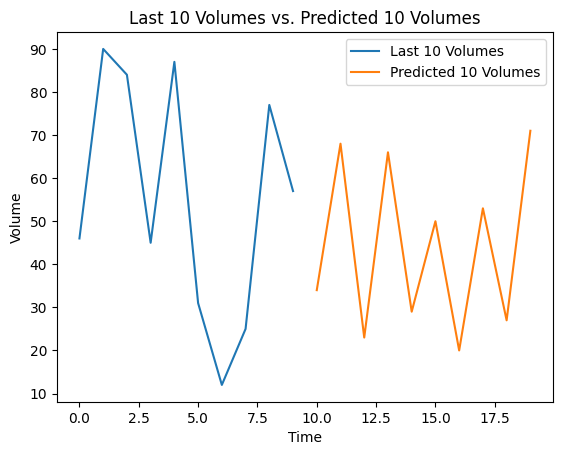

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def predict_next_10_volumes(data):
    """
    Predicts the next 10 volumes using a Markov Chain.

    Args:
        data: List of volume data.

    Returns:
        List of predicted next 10 volumes.
    """

    # Discretize volumes into states (e.g., Low, Medium, High)
    # Example discretization using quantiles:
    low_threshold = np.quantile(data, 0.33)
    high_threshold = np.quantile(data, 0.66)
    states = np.where(data < low_threshold, 'Low', np.where(data > high_threshold, 'High', 'Medium'))

    # Create transition state matrix
    unique_states = np.unique(states)
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transition_matrix.loc[current_state, next_state] += 1

    # Normalize transition matrix to get probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Predict next 10 volumes
    current_state = states[-1]  # Last observed state
    predicted_volumes = []
    for _ in range(10):
        predicted_next_state = transition_matrix[transition_matrix.index == current_state].idxmax(axis=1).values[0]
        # Map predicted state back to volume range
        if predicted_next_state == 'Low':
            predicted_volume = np.random.randint(int(data.min()), int(low_threshold))
        elif predicted_next_state == 'High':
            predicted_volume = np.random.randint(int(high_threshold), int(data.max()))
        else:  # Medium
            predicted_volume = np.random.randint(int(low_threshold), int(high_threshold))
        predicted_volumes.append(predicted_volume)
        current_state = predicted_next_state

    return predicted_volumes

# Example usage:
data = np.random.randint(10, 101, size=100)  # Replace with your actual data
predicted_volumes = predict_next_10_volumes(data)
print("Predicted next 10 volumes:", predicted_volumes)

# Assuming you have the original data in a variable called 'data'
last_10_volumes = data[-10:]

# Create x-axis values for plotting
x_values_last_10 = np.arange(len(last_10_volumes))
x_values_predicted = np.arange(len(last_10_volumes), len(last_10_volumes) + len(predicted_volumes))

# Plot the last 10 volumes
plt.plot(x_values_last_10, last_10_volumes, label='Last 10 Volumes')

# Plot the predicted 10 volumes
plt.plot(x_values_predicted, predicted_volumes, label='Predicted 10 Volumes')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('Last 10 Volumes vs. Predicted 10 Volumes')

# Add legend
plt.legend()

# Display the chart
plt.show()